In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.callback import Callback
from pymoo.core.evaluator import Evaluator
from pymoo.core.problem import Problem
from pymoo.core.termination import NoTermination
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.gauss import GaussianMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.problems.static import StaticProblem

In [6]:
# --- 1. 問題定義 ---
# Ackley関数の最適化問題として再定義
N_VAR = 2
problem = Problem(n_var=N_VAR,
                  n_obj=1,          # 目的変数の数を1に変更
                  n_constr=0,
                  xl=-32.768,     # Ackley関数の一般的な探索範囲
                  xu=32.768)

# --- 2. アルゴリズムの設定 ---
# deapでのToolbox設定 (交叉、突然変異、選択) に相当する部分をpymooで実装

# バイナリトーナメント選択のための比較関数
def binary_tournament(pop, P, **kwargs):
    n_tournaments, n_competitors = P.shape
    if n_competitors != 2:
        raise ValueError("このトーナメント関数は2個体選択(pressure=2)専用です。")

    S = np.full(n_tournaments, -1, dtype=int)
    for i in range(n_tournaments):
        a, b = P[i]
        if pop[a].F < pop[b].F:
            S[i] = a
        else:
            S[i] = b
    return S

# GAアルゴリズムに詳細な設定を適用
algorithm = GA(
    pop_size=1000,
    sampling=FloatRandomSampling(),
    selection=TournamentSelection(func_comp=binary_tournament, pressure=2),
    crossover=SBX(prob=0.5, eta=15),
    mutation=GaussianMutation(prob=0.2, sigma=5),
    eliminate_duplicates=True
)


# --- 3. コールバックと終了条件の設定 ---
N_GEN = 100 # 世代数

# プログレスバー表示とデータ収集を兼ねるカスタムCallbackクラス
class CustomCallback(Callback):
    def __init__(self, n_gen):
        super().__init__()
        self.pbar = tqdm(total=n_gen, desc="Evolving")
        self.data = {"avg": [], "min": [], "std": []}

    def notify(self, algorithm):
        pop_f = algorithm.pop.get("F")
        self.data["avg"].append(np.mean(pop_f))
        self.data["min"].append(np.min(pop_f))
        self.data["std"].append(np.std(pop_f))
        self.pbar.update(1)
        self.pbar.set_postfix(min_f=f"{self.data['min'][-1]:.4f}")

    def __del__(self):
        self.pbar.close()

# コールバックを初期化
callback = CustomCallback(n_gen=N_GEN)

# --- 4. GAの実行 (Ask-Tellインターフェース) ---

# アルゴリズムが自動で終了しないように設定
termination = NoTermination()

# アルゴリズムを問題と終了条件でセットアップ
algorithm.setup(problem, termination=termination)

# 乱数シードを固定
np.random.seed(1)

Evolving: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it, min_f=0.0725]


In [7]:

# 指定した世代数分の最適化計算を実行
for n_gen in range(N_GEN):
    # アルゴリズムに次に評価すべき個体群を問い合わせる
    pop = algorithm.ask()

    # 個体群の設計変数値を取得
    X = pop.get("X")

    # Ackley関数の値を計算
    a, b, c, d = 20, 0.2, 2 * np.pi, N_VAR
    sum_sq_term = np.sum(X**2, axis=1)
    cos_term = np.sum(np.cos(c * X), axis=1)
    term1 = -a * np.exp(-b * np.sqrt(sum_sq_term / d))
    term2 = -np.exp(cos_term / d)
    F = term1 + term2 + a + np.e
    F = F[:, np.newaxis]

    # 評価結果をpopオブジェクトに格納
    static = StaticProblem(problem, F=F)
    Evaluator().eval(static, pop)

    # 評価済みの個体群をアルゴリズムにフィードバック
    algorithm.tell(infills=pop)

    # コールバックを呼び出して進捗を更新
    callback.notify(algorithm)

# --- 5. 結果の表示 ---

# アルゴリズムから最終結果を取得
res = algorithm.result()


-- End of evolution --
individual: [ 1.66694729e-15 -3.80462934e-16]
fitness: 3.9968028886505635e-15


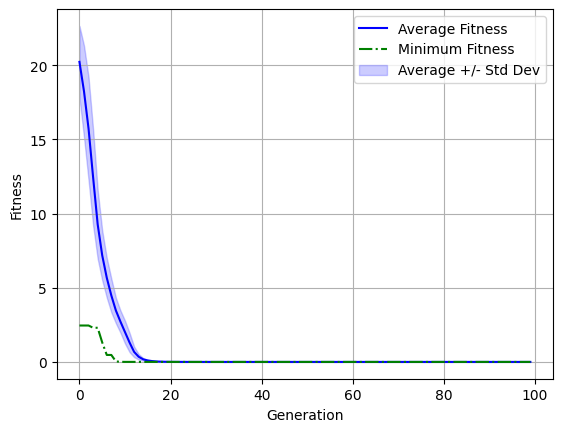

In [8]:
# --- 5. 結果の表示 ---
# deapでの hof[0] や hof[0].fitness.values に相当します。
print("\n-- End of evolution --")
print(f"individual: {res.X}")
print(f"fitness: {res.F[0]}")

# --- 6. グラフの描画 ---
# Callbackオブジェクトから統計データを直接取得してグラフを作成します。
avg_list = np.array(callback.data["avg"])
min_list = np.array(callback.data["min"])
std_list = np.array(callback.data["std"])
n_gen = len(min_list)

gen = np.arange(n_gen)
#fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
fig, ax = plt.subplots()

# mean with solid line
line1 = ax.plot(gen, avg_list, "b-", label="Average Fitness")

# min with dashed line
line2 = ax.plot(gen, min_list, "g-.", label="Minimum Fitness")

ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")

# 平均 +/- 標準偏差の範囲を塗りつぶしで表示
std_upper = avg_list + std_list
std_lower = avg_list - std_list
ax.fill_between(gen, std_lower, std_upper,
                 color='b', alpha=0.2, label="Average +/- Std Dev")

ax.legend(loc="upper right")
plt.grid(True)
plt.show()